# GridFM Fine-tuning Tutorial

# Fine-tuning an existing GridFM

Here we demonstrate how to leverage a previously pre-trained model to perform fine-tuning on downstream tasks. Specifically, we focus on the Power Flow (PF) problem, a fundamental task in power systems that involves computing the steady-state voltages and power injections in the grid.

The workflow consists of the following steps:

- Similar to pre-training, the first step is to normalize the data and convert the power grid into a PyTorch Geometric graph representation.

- A DataLoader then loads the data for fine-tuning.

- In the PF use case, which closely aligns with the pre-training setup, we adjust the masking strategy to match the PF problem, i.e. no longer using random masking. For other use cases, it may be necessary to modify the decoder or add additional heads or decoder layers to the pre-trained autoencoder.

-  The model is then trained to reconstruct the PF grid state. The loss function consists of a physics-informed loss based on node-wise power balance equations (ensuring power injected equals power consumed or absorbed).  

$$
\mathcal{L}_{\text{PBE}} = \frac{1}{N} \sum_{i=1}^N \left| (P_{G,i} - P_{D,i}) + j(Q_{G,i} - Q_{D,i}) - S_{\text{injection}, i} \right|
$$

- Finally, we visualize fine-tuning performance.

In [1]:
from gridfm_graphkit.datasets.powergrid import GridDatasetMem
from gridfm_graphkit.datasets.data_normalization import BaseMVANormalizer
from gridfm_graphkit.training.trainer import Trainer
from gridfm_graphkit.datasets.utils import split_dataset
from gridfm_graphkit.datasets.transforms import AddPFMask
from gridfm_graphkit.training.callbacks import EarlyStopper
from gridfm_graphkit.training.plugins import MetricsTrackerPlugin
from gridfm_graphkit.utils.loss import PBELoss

# Standard Libraries
import torch
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import os

## Load the training data and create the dataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Select from which grid case file the simulated AC powerflow data should be used
data_dir = "../data/case30_ieee"

In [4]:
node_normalizer, edge_normalizer = (
    BaseMVANormalizer(node_data=True),
    BaseMVANormalizer(node_data=False),
)

dataset = GridDatasetMem(
    root=data_dir,
    norm_method="baseMVAnorm",
    node_normalizer=node_normalizer,
    edge_normalizer=edge_normalizer,
    pe_dim=20,  # Dimension of positional encoding
    transform=AddPFMask(),
)

## Split the dataset for training and validation

In [5]:
node_normalizer.to(device)
edge_normalizer.to(device)

train_dataset, val_dataset, _ = split_dataset(
    dataset, data_dir, val_ratio=0.1, test_ratio=0.1
)

## Create Pytorch dataloaders for training, validation and testing

In [6]:
# Create DataLoaders with batches. The data-Loaders also take care of the masking for the powerflow problem formulation, the masking strategy in the configuration yaml needs to be set to "pf".
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Load the model

In [7]:
model = torch.load(
    "../models/GridFM_v0_2_3.pth", weights_only=False, map_location=device
).to(device)

In [8]:
# Select optimizer and learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0001,
)
# Adjust learning rate while training
scheduler = ReduceLROnPlateau(optimizer)

In [9]:
# This block only for compatibility with original code - does not do anything here
best_model_path = os.path.join("best_checkpoint.pth")
early_stopper = EarlyStopper(best_model_path, -1, 0)

In [10]:
loss_fn = PBELoss()

## Fine-tune the model

In [11]:
# Plugin logs validation losses and saves to file for later use
log_val_loss_plugin = MetricsTrackerPlugin()

In [12]:
# Setup Trainer Instance -> /gridfm_graphkit/training/trainer.py
trainer = Trainer(
    model=model,
    optimizer=optimizer,
    device=device,
    loss_fn=loss_fn,
    early_stopper=early_stopper,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    lr_scheduler=scheduler,
    plugins=[log_val_loss_plugin],
)

In [ ]:
trainer.train(epochs=15)

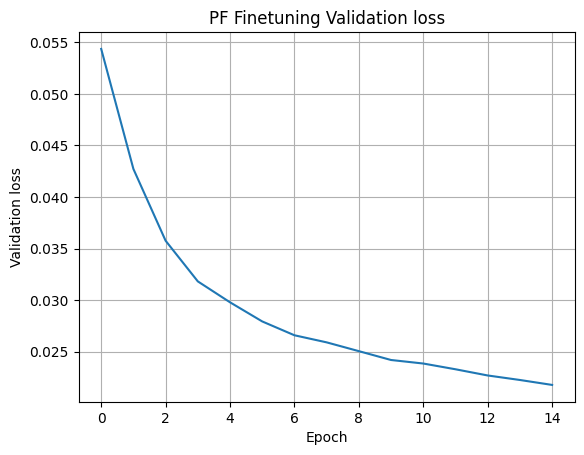

In [14]:
# Plot validation loss vs. training epochs
val_loss = log_val_loss_plugin.get_losses()
plt.plot(val_loss)
plt.grid()
plt.title("PF Finetuning Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Validation loss")
plt.show()